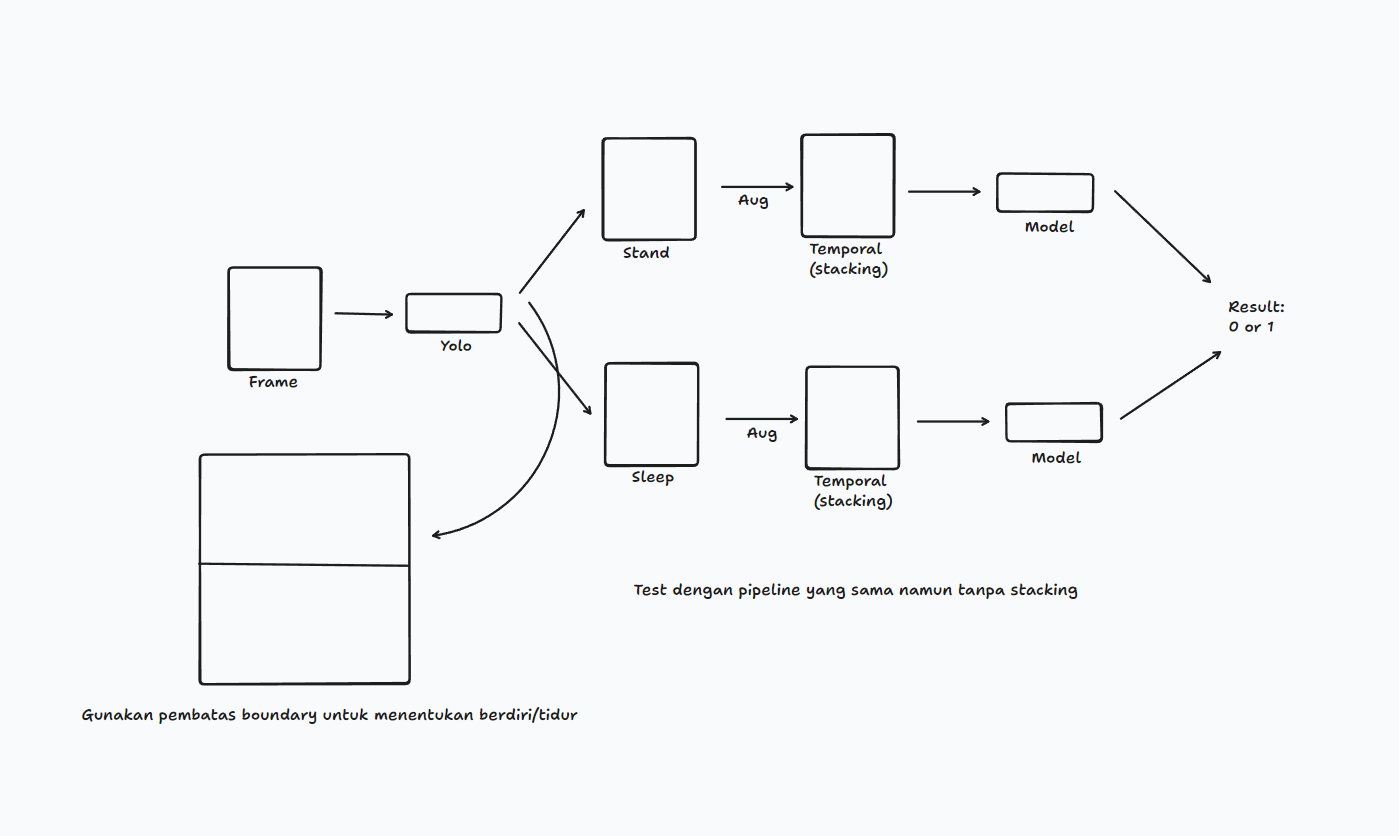

# Import Library

In [1]:
import os
import random
from collections import Counter, defaultdict, deque
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import gaussian_filter1d
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from tqdm import tqdm
from model import MobileNetV3Berdiri, MobileNetV3TidakBerdiri


c:\Users\ASUS\anaconda3\envs\venv\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Dataset Setup

In [2]:
def load_image_sequences(root_dir):
    sequences = []
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if not os.path.isdir(subject_path):
            continue
        for label in os.listdir(subject_path):
            label_path = os.path.join(subject_path, label)
            if not os.path.isdir(label_path):
                continue
            for action in os.listdir(label_path):
                action_path = os.path.join(label_path, action)
                if not os.path.isdir(action_path):
                    continue
                image_paths = sorted(glob(os.path.join(action_path, '*.jpg')))
                if len(image_paths) == 0:
                    continue
                action_name = "_".join(action.split('_')[1:]) if '_' in action else action
                sequences.append({
                    'subject': subject,
                    'label': label,
                    'action': action_name,
                    'image_paths': image_paths
                })
    return sequences

root_dir = 'Processed/train'
sequences = load_image_sequences(root_dir)

fall_sequences = [s for s in sequences if s['label'] == 'fall']
non_fall_sequences = [s for s in sequences if s['label'] == 'non_fall']

train_fall, test_fall = train_test_split(fall_sequences, test_size=0.2, random_state=42)
train_non_fall, test_non_fall = train_test_split(non_fall_sequences, test_size=0.2, random_state=42)

train_sequences = train_fall + train_non_fall
test_sequences = test_fall + test_non_fall

In [3]:
def apply_transformations(sequences, transform):
    transformed_sequences = []
    for seq in sequences:
        transformed_images = []
        for img_path in seq['image_paths']:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = np.expand_dims(img, axis=2)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = np.array(img, dtype=np.uint8)
            augmented_img = transform(transforms.ToPILImage()(img))
            transformed_images.append(augmented_img)

        transformed_sequences.append({
            'subject': seq['subject'],
            'label': seq['label'],
            'action': seq['action'],
            'image_tensors': transformed_images
        })
    return transformed_sequences

augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_augmented = apply_transformations(train_sequences, augmentation)
test_transformed = apply_transformations(test_sequences, test_transform)

In [4]:
class SingleFrameActionDataset(Dataset):
    def __init__(self, sequences):
        self.data = []

        for seq in sequences:
            label = 1 if seq['label'] == 'fall' else 0
            for img_tensor in seq['image_tensors']:
                self.data.append((img_tensor, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

train_single_frame_dataset = SingleFrameActionDataset(train_augmented)
test_single_frame_dataset = SingleFrameActionDataset(test_transformed)

batch_size = 4
train_single_frame_loader = DataLoader(train_single_frame_dataset, batch_size=batch_size, shuffle=True)
test_single_frame_loader = DataLoader(test_single_frame_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_single_frame_loader:
    assert images.shape[1:] == (3, 224, 224), f"Shape mismatch in batch: {images.shape}"
    print(f"Batch size: {images.shape[0]}, Image shape: {images.shape[1:]}")
    break

print(f"Total single frame train samples: {len(train_single_frame_dataset)}")
print(f"Total single frame test samples: {len(test_single_frame_dataset)}")

Batch size: 4, Image shape: torch.Size([3, 224, 224])
Total single frame train samples: 3384
Total single frame test samples: 847


# Model

On this section, we separate model for high promising result. This approach based on our evaluation that we cant generalize on one model, because several method will significanly wrong on stand or sleep (stand give high result but sleep not, or sebaliknya :v)

## Stand

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_stand = MobileNetV3Berdiri(pretrained=True).to(device)
criterion_stand = nn.CrossEntropyLoss()

optimizer_stand = torch.optim.AdamW(model_stand.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_stand = torch.optim.lr_scheduler.StepLR(optimizer_stand, step_size=3, gamma=0.7)

c:\Users\ASUS\anaconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Not Stand

In [22]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_not_stand = MobileNetV3TidakBerdiri(pretrained=True).to(device)

# Loss, Optimizer, and Scheduler
criterion_not_stand = nn.CrossEntropyLoss()
optimizer_not_stand = torch.optim.AdamW(model_not_stand.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_not_stand = torch.optim.lr_scheduler.StepLR(optimizer_not_stand, step_size=3, gamma=0.7)

# Train

In [7]:
def train_model(model, criterion, optimizer, scheduler, train_loader, num_epochs=10, save_path=None):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        scheduler.step()

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

In [8]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_accuracy = correct / total * 100
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss, test_accuracy

In [9]:
train_model(
    model=model_stand,
    criterion=criterion_stand,
    optimizer=optimizer_stand,
    scheduler=scheduler_stand,
    train_loader=train_single_frame_loader,
    num_epochs=3,
    save_path="mobilenetv3_berdiri_model.pth"  # Nama file tempat model disimpan
)

# Evaluasi model
evaluate_model(
    model=model_stand,
    test_loader=test_single_frame_loader,
    criterion=criterion_stand
)

Epoch [1/3], Loss: 0.3484, Accuracy: 85.28%


Epoch [2/3], Loss: 0.2206, Accuracy: 92.02%


Epoch [3/3], Loss: 0.1402, Accuracy: 95.89%
Model saved to mobilenetv3_berdiri_model.pth


Test Loss: 0.3338, Test Accuracy: 87.84%


(0.3337812819410294, 87.83943329397876)

In [11]:
train_model(
    model=model_not_stand,
    criterion=criterion_not_stand,
    optimizer=optimizer_not_stand,
    scheduler=scheduler_not_stand,
    train_loader=train_single_frame_loader,
    num_epochs=3,
    save_path="mobilenetv3_tidak_berdiri_model.pth"  # Nama file tempat model disimpan
)

# Evaluasi model
evaluate_model(
    model=model_not_stand,
    test_loader=test_single_frame_loader,
    criterion=criterion_not_stand
)

Epoch [1/3], Loss: 0.1546, Accuracy: 95.60%


Epoch [2/3], Loss: 0.1152, Accuracy: 97.46%


Epoch [3/3], Loss: 0.1199, Accuracy: 97.22%
Model saved to mobilenetv3_tidak_berdiri_model.pth


Test Loss: 0.2346, Test Accuracy: 91.50%


(0.23457868713385113, 91.49940968122786)

--- 

In [13]:
class TestingDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob(os.path.join(image_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found or unable to read: {img_path}")

        # Convert grayscale to RGB
        img = np.expand_dims(img, axis=2)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Load testing dataset
testing_dataset = TestingDataset(image_dir=test_directory, transform=data_transform)
testing_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)
